In [1]:
import pandas as pd
from os import path

In [2]:
filenames = {}
for year in range(2007,2017):
    for semester in [1,2,3]:
        filename = 'data/master_%d_%d.csv' % (year, semester)
        filenames[(year,semester)] = filename

projects = {}
for year in range(2007,2017):
    for semester in ['automne','printemps']:
        filename = 'data/projet_master_%d_%s.csv' % (year, semester)
        if(path.isfile(filename)):
            projects[(year,semester)] = filename

In [3]:
# Collecting all the master students by semester

master_students = {}
for key in filenames.keys():
    master_students[key[1]] = []
for key,filename in filenames.items():
    master_students[key[1]].append(pd.read_csv(filename, header=0, index_col='No Sciper'))
for semester,tables in master_students.items():
    master_students[semester] = pd.concat(tables)
    master_students[semester].drop(['Unnamed: 0', 'semester'],axis=1,inplace=True)
    master_students[semester] = master_students[semester].rename(columns = {'year':('year_s'+str(semester))})
#master_students[1]

In [4]:
# remove students with an entry in the exchange column
# and remove column 'Type Echange' as it is irrelevant now
for semester,tables in master_students.items():
    master_students[semester] = \
        master_students[semester][master_students[semester].loc[:,'Type Echange'].isnull() == True]
    master_students[semester] = master_students[semester].dropna(axis=1, how='all')
#frames[1]['Type Echange'].value_counts(dropna=False)
#frames[1]

In [5]:
# Collecting all the master projects by semester

master_projects = []
count = 0
total_len = 0
for key,filename in projects.items():
    master_projects.append(pd.read_csv(filename, header=0, index_col='No Sciper'))
    total_len += len(master_projects[count].index)
    count += 1
print(total_len)
master_projects = pd.concat(master_projects)
#master_projects
master_projects.drop(['Unnamed: 0'],axis=1,inplace=True)
master_projects = master_projects.rename(columns = {'year':'year_pr'})

128


In [6]:
# remove entries which appear under 'Type Echange'
master_projects = master_projects[master_projects.loc[:,'Type Echange'].isnull() == True]
master_projects = master_projects.dropna(axis=1, how='all')

In [7]:
#master_projects

Above preprocessing of the data -- actual stuff starts now

In [29]:
# check if there are students in the first 2 semesters
cols_to_use = master_students[1].columns.difference(master_students[2].columns)
master_studs_1_2 = pd.merge(master_students[2], 
                        master_students[1][cols_to_use], left_index=True, right_index=True, how='inner')
# master students without a specialization or minor
master_studs_1_2_wsm = master_studs_1_2[(master_studs_1_2['Mineur'].isnull() == True) \
                            & (master_studs_1_2['Spécialisation'].isnull() == True)]
master_studs_1_2_wsm = master_studs_1_2_wsm.dropna(axis = 1, how = 'all')
#master_students[1].loc[153746]
#master_studs_1_2

In [30]:
cols_to_use = master_projects.columns.difference(master_studs_1_2_wsm.columns)
master_studs_1_2_wsm_project = pd.merge(master_studs_1_2_wsm, master_projects[cols_to_use],
                                    left_index=True, right_index=True, how='inner')
#master_studs_1_2_wsm_project

In [31]:
id12 = master_studs_1_2.index.difference(master_students[3].index)
master_studs_1_2_only = master_studs_1_2.ix[id12]
#master_studs_1_2_only

In [36]:
# All students who did 1st and 2nd sem and the master project

cols_to_use = master_studs_1_2_only.columns.difference(master_projects.columns)
master_studs_1_2_only_project = pd.merge(master_projects, master_studs_1_2_only[cols_to_use],
                                    left_index=True, right_index=True, how='inner')
#master_studs_1_2_only_project

In [38]:
# find the students in all 3 semesters
cols_to_use = master_studs_1_2.columns.difference(master_students[3].columns)
master_studs_1_2_3 = pd.merge(master_students[3], 
                        master_studs_1_2[cols_to_use], left_index=True, right_index=True, how='inner')
#master_studs_1_2_3

In [39]:
cols_to_use = master_projects.columns.difference(master_studs_1_2_3.columns)
master_studs_1_2_3_project = pd.merge(master_studs_1_2_3, master_projects[cols_to_use],
                                    left_index=True, right_index=True, how='inner')
master_studs_1_2_3_project

,Civilité,Mineur,Nom Prénom,Spécialisation,Statut,year_s3,year_s1,year_s2,semester,year_pr
No Sciper,,,,,,,,,,
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2012,2008,2008,printemps,2010
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2012,2008,2008,automne,2010
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2012,2008,2009,printemps,2010
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2012,2008,2009,automne,2010
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2009,2008,2008,printemps,2010
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2009,2008,2008,automne,2010
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2009,2008,2009,printemps,2010
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,2009,2008,2009,automne,2010
154573,Madame,NaN,Benabdallah Zeineb,Biocomputing,Présent,2009,2007,2008,printemps,2009


In [40]:
master_students_final = [master_studs_1_2_only_project, master_studs_1_2_3_project]

In [41]:
master = pd.concat(master_students_final)
master = master[['Civilité','Nom Prénom','semester', 'year_pr','year_s1','year_s2','year_s3']]
master = master.drop_duplicates()
master

,Civilité,Nom Prénom,semester,year_pr,year_s1,year_s2,year_s3
No Sciper,,,,,,,
160213,Monsieur,Bécholey Alexandre,printemps,2009,2008,2008,NaN
160213,Monsieur,Bécholey Alexandre,printemps,2009,2008,2007,NaN
160213,Monsieur,Bécholey Alexandre,automne,2009,2008,2008,NaN
160213,Monsieur,Bécholey Alexandre,automne,2009,2008,2007,NaN
166075,Monsieur,Amiguet Jérôme,automne,2016,2014,2014,NaN
166075,Monsieur,Amiguet Jérôme,automne,2016,2015,2014,NaN
166075,Monsieur,Amiguet Jérôme,automne,2016,2014,2015,NaN
166075,Monsieur,Amiguet Jérôme,automne,2016,2015,2015,NaN
166805,Monsieur,Fleury Marc-Olivier,automne,2008,2007,2007,NaN


In [42]:
#master_group = master.groupby(master.index).min()
master_group = master.groupby(master.index)
master_group = master_group.agg({'Civilité':'last','Nom Prénom':'last','semester':'first','year_pr':'first',
                 'year_s1':'min','year_s2':'min','year_s3':'min'})
master_group.head()

,year_s3,year_s1,Civilité,year_pr,Nom Prénom,semester,year_s2
No Sciper,,,,,,,
146742,2009.0,2008,Monsieur,2010,Marx Clément,printemps,2008
154573,2008.0,2007,Madame,2009,Benabdallah Zeineb,printemps,2007
159516,2009.0,2008,Monsieur,2009,Raja Yanick,printemps,2008
160213,NaN,2008,Monsieur,2009,Bécholey Alexandre,printemps,2007
160225,2008.0,2007,Monsieur,2008,Cassata Alexandre,printemps,2007


In [43]:
def compute_duration(row):
    semester = ''
    if (row.year_s3 == row.year_pr):
        semester = 'automne'
    else:
        semester = row.semester
        
    if (row.year_s1 < row.year_s2):
        if(semester == 'printemps'):
            return row.year_pr - row.year_s1
        else:
            return row.year_pr - row.year_s1 + 0.5
    else:
        if(semester == 'printemps'):
            return row.year_pr - row.year_s2
        else:
            return row.year_pr - row.year_s2 + 0.5
master_group['duration'] = master_group.apply(compute_duration, axis = 1)
master_group = master_group[master_group.duration.notnull()]
master_group.head()

,year_s3,year_s1,Civilité,year_pr,Nom Prénom,semester,year_s2,duration
No Sciper,,,,,,,,
146742,2009.0,2008,Monsieur,2010,Marx Clément,printemps,2008,2.0
154573,2008.0,2007,Madame,2009,Benabdallah Zeineb,printemps,2007,2.0
159516,2009.0,2008,Monsieur,2009,Raja Yanick,printemps,2008,1.5
160213,NaN,2008,Monsieur,2009,Bécholey Alexandre,printemps,2007,2.0
160225,2008.0,2007,Monsieur,2008,Cassata Alexandre,printemps,2007,1.5


# Average duration for master students:

In [44]:
master_duration = master_group['duration'].mean()
master_duration

1.9464285714285714

In [45]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

Monsieur    100
Madame       12
Name: Civilité, dtype: int64


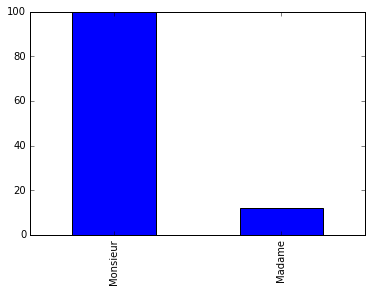

In [46]:
print(master_group["Civilité"].value_counts())
master_group["Civilité"].value_counts().plot(kind='bar')

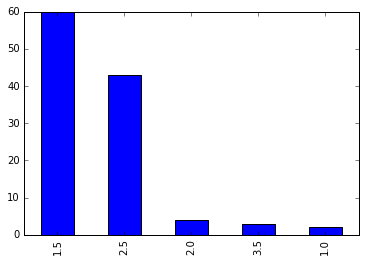

In [47]:
master_group["duration"].value_counts().plot(kind='bar')

In [48]:
# Apparently there is one case in which the duration is of 1 year
master_group[master_group.duration == 1.0]

,year_s3,year_s1,Civilité,year_pr,Nom Prénom,semester,year_s2,duration
No Sciper,,,,,,,,
183605,NaN,2008,Madame,2009,Kostic Teodora,printemps,2008,1.0
191471,NaN,2009,Monsieur,2010,Brot Benoît,printemps,2009,1.0


# Master Specialization

In [49]:
print(master_students[1][master_students[1]['Spécialisation'].notnull()].count())


Civilité          86
Mineur             0
Nom Prénom        86
Spécialisation    86
Statut            86
year_s1           86
dtype: int64


In [50]:
master_spec = [master_studs_1_2_only_project, master_studs_1_2_3_project]
master_spec = pd.concat(master_spec)
master_spec = master_spec[master_spec['Spécialisation'].notnull()]
master_spec = master_spec.drop_duplicates()
master_spec.head()

,Civilité,Mineur,Nom Prénom,Spécialisation,Statut,semester,year_pr,year_s1,year_s2,year_s3
No Sciper,,,,,,,,,,
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,printemps,2010,2008,2008,2012.0
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,automne,2010,2008,2008,2012.0
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,printemps,2010,2008,2009,2012.0
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,automne,2010,2008,2009,2012.0
146742,Monsieur,NaN,Marx Clément,"Signals, Images and Interfaces",Présent,printemps,2010,2008,2008,2009.0


In [51]:
#master_group = master.groupby(master.index).min()
master_spec = master_spec.groupby(master_spec.index)
master_spec = master_spec.agg({'Civilité':'last','Spécialisation':'last', 'Nom Prénom':'last','semester':'first',
                               'year_pr':'first','year_s1':'min','year_s2':'min','year_s3':'min'})
master_spec

,semester,year_s1,Spécialisation,Civilité,year_pr,year_s3,Nom Prénom,year_s2
No Sciper,,,,,,,,
146742,printemps,2008,"Signals, Images and Interfaces",Monsieur,2010,2009.0,Marx Clément,2008
154573,printemps,2007,Biocomputing,Madame,2009,2008.0,Benabdallah Zeineb,2007
165819,printemps,2007,Foundations of Software,Monsieur,2008,2008.0,Hofer Thomas,2007
175702,printemps,2009,Foundations of Software,Monsieur,2010,2010.0,Steiger Robin,2009
179878,printemps,2007,Internet computing,Monsieur,2008,2008.0,Muriel Hugo Marcelo,2007
180072,printemps,2007,Internet computing,Monsieur,2008,2008.0,Campora Simone,2007
180731,printemps,2010,"Signals, Images and Interfaces",Monsieur,2011,2011.0,Bricola Jean-Charles,2010
185522,printemps,2008,Internet computing,Monsieur,2009,2009.0,Stroe Dante,2008
185523,printemps,2008,Internet computing,Monsieur,2009,2009.0,Cunha Pedro Andre,2008


In [52]:
# ONLY students who have a specialization listed in semester 3

master_spec['duration'] = master_spec.apply(compute_duration, axis = 1)
master_spec = master_spec[master_spec.duration.notnull()]
master_spec

,semester,year_s1,Spécialisation,Civilité,year_pr,year_s3,Nom Prénom,year_s2,duration
No Sciper,,,,,,,,,
146742,printemps,2008,"Signals, Images and Interfaces",Monsieur,2010,2009.0,Marx Clément,2008,2.0
154573,printemps,2007,Biocomputing,Madame,2009,2008.0,Benabdallah Zeineb,2007,2.0
165819,printemps,2007,Foundations of Software,Monsieur,2008,2008.0,Hofer Thomas,2007,1.5
175702,printemps,2009,Foundations of Software,Monsieur,2010,2010.0,Steiger Robin,2009,1.5
179878,printemps,2007,Internet computing,Monsieur,2008,2008.0,Muriel Hugo Marcelo,2007,1.5
180072,printemps,2007,Internet computing,Monsieur,2008,2008.0,Campora Simone,2007,1.5
180731,printemps,2010,"Signals, Images and Interfaces",Monsieur,2011,2011.0,Bricola Jean-Charles,2010,1.5
185522,printemps,2008,Internet computing,Monsieur,2009,2009.0,Stroe Dante,2008,1.5
185523,printemps,2008,Internet computing,Monsieur,2009,2009.0,Cunha Pedro Andre,2008,1.5


In [53]:
master_spec_group = master_spec.groupby(['Spécialisation'])
master_spec_group['duration'].agg(['mean', 'size'])

,mean,size
Spécialisation,,
Biocomputing,2.000000,1
Computer Engineering - SP,2.500000,2
Foundations of Software,2.166667,6
Information Security - SP,2.500000,1
Internet computing,2.050000,10
Service science,2.500000,1
"Signals, Images and Interfaces",2.000000,3
Software Systems,2.500000,2
